# Covid Classifier Model
### Goals
Classify:
- Normal CXR
- Viral Pneumonia CXR
- COVID CXR

## Create Directories for Dataset
Separate the data to use later as generators.

In [3]:
# Heatmaps, matriz de confusion, comments.
import os

BASE_PATH = '/home/hivini/learn/research/new-covid'
ORIGINAL_DATASET_DIR = os.path.join(BASE_PATH, 'COVID-19_Radiography_Dataset')
ORIGINAL_VIRAL_DIR = os.path.join(ORIGINAL_DATASET_DIR, 'Viral Pneumonia')
ORIGINAL_COVID_DIR = os.path.join(ORIGINAL_DATASET_DIR, 'COVID')
ORIGINAL_NORMAL_DIR = os.path.join(ORIGINAL_DATASET_DIR, 'Normal')
DATASET_DIR = os.path.join(BASE_PATH, 'small_dataset')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VALIDATION_DIR = os.path.join(DATASET_DIR, 'validation')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
TRAIN_VIRAL_DIR = os.path.join(TRAIN_DIR, 'viral_pneumonia')
TRAIN_COVID_DIR = os.path.join(TRAIN_DIR, 'covid')
TRAIN_NORMAL_DIR = os.path.join(TRAIN_DIR, 'normal')
VALIDATION_VIRAL_DIR = os.path.join(VALIDATION_DIR, 'viral_pneumonia')
VALIDATION_COVID_DIR = os.path.join(VALIDATION_DIR, 'covid')
VALIDATION_NORMAL_DIR = os.path.join(VALIDATION_DIR, 'normal')
TEST_VIRAL_DIR = os.path.join(TEST_DIR, 'viral_pneumonia')
TEST_COVID_DIR = os.path.join(TEST_DIR, 'covid')
TEST_NORMAL_DIR = os.path.join(TEST_DIR, 'normal')


def createDir(path: str) -> None:
    if not os.path.exists(path):
        os.mkdir(path)


createDir(DATASET_DIR)
createDir(TRAIN_DIR)
createDir(VALIDATION_DIR)
createDir(TEST_DIR)
createDir(TRAIN_VIRAL_DIR)
createDir(TRAIN_COVID_DIR)
createDir(TRAIN_NORMAL_DIR)
createDir(VALIDATION_VIRAL_DIR)
createDir(VALIDATION_COVID_DIR)
createDir(VALIDATION_NORMAL_DIR)
createDir(TEST_VIRAL_DIR)
createDir(TEST_COVID_DIR)
createDir(TEST_NORMAL_DIR)


In [4]:
import numpy as np
import shutil


def generate_sets(source: str):
    allFiles = os.listdir(source)
    np.random.shuffle(allFiles)
    return np.split(np.array(allFiles), [int(len(allFiles)*0.7), int(len(allFiles)*0.85)])


def saveAndSeparateFiles(src_dir: str, train_dir: str, val_dir: str, test_dir):
    train_fnames, val_fnames, test_fnames = generate_sets(src_dir)
    for fname in train_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(train_dir, fname)
        shutil.copyfile(src, dst)

    for fname in val_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(val_dir, fname)
        shutil.copyfile(src, dst)

    for fname in test_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(test_dir, fname)
        shutil.copyfile(src, dst)

create = False
if create:
    saveAndSeparateFiles(ORIGINAL_NORMAL_DIR, TRAIN_NORMAL_DIR,
                        VALIDATION_NORMAL_DIR, TEST_NORMAL_DIR)
    saveAndSeparateFiles(ORIGINAL_COVID_DIR, TRAIN_COVID_DIR,
                        VALIDATION_COVID_DIR, TEST_COVID_DIR)
    saveAndSeparateFiles(ORIGINAL_VIRAL_DIR, TRAIN_VIRAL_DIR,
                        VALIDATION_VIRAL_DIR, TEST_VIRAL_DIR)


## Counting our images

2021-10-15 09:32:24.555020: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


{'covid': 2531, 'normal': 7134, 'viral': 941}


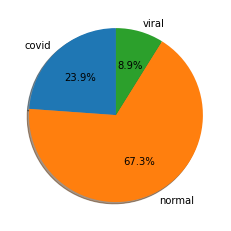

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
normal_train = tf.io.gfile.glob(TRAIN_NORMAL_DIR + '/*')
viral_train = tf.io.gfile.glob(TRAIN_VIRAL_DIR + '/*')
covid_train = tf.io.gfile.glob(TRAIN_COVID_DIR + '/*')

# Plotting Distribution of Each Classes
image_count = {'covid': len(covid_train), 'normal': len(
    normal_train), 'viral': len(viral_train)}
print(image_count)
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels=image_count.keys(),
        shadow=True,
        autopct='%1.1f%%',
        startangle=90)
plt.show()


## Create our Covnet Model
In this case we are doing a multi class classification, our total clases are 3:
- Viral CXR
- Covid CXR
- Normal CXR

Our neural network will output neurons as 3 classes that will calculate the probability of being one using the softmax function. 

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=10,
    zoom_range=0.1,  # Randomly zoom image
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

# train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
evaluate_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

print(train_generator.class_indices)

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

print(validation_generator.class_indices)

test_generator = evaluate_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

print(test_generator.class_indices)


Found 10606 images belonging to 3 classes.
{'covid': 0, 'normal': 1, 'viral_pneumonia': 2}
Found 2273 images belonging to 3 classes.
{'covid': 0, 'normal': 1, 'viral_pneumonia': 2}
Found 2274 images belonging to 3 classes.
{'covid': 0, 'normal': 1, 'viral_pneumonia': 2}


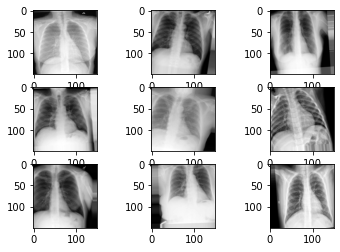

In [5]:
for X_batch, y_batch in train_generator:
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(150, 150), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

In [6]:
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend

# We want to make sure we start from the start when training our model everytime we run it.
backend.clear_session()

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()


2021-10-10 18:47:12.881778: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-10 18:47:12.891781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-10 18:47:13.336200: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-10 18:47:13.336504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.215GHz coreCount: 46 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 357.69GiB/s
2021-10-10 18:47:13.336537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-10 18:47:13.384368: I tensorflow/stre

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

In [7]:
from keras import optimizers

# opt = RMSprop(lr=0.0001, decay=1e-6)
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=2000,
    decay_rate=0.9)
opt = optimizers.Adam(learning_rate=lr_schedule)

# try with metric categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [8]:
import numpy as np
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

classes = train_generator.classes
class_weights = class_weight.compute_class_weight(None,
                                                 np.unique(classes),
                                                 classes)
best_model_path = os.path.join(BASE_PATH, 'best_model.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(best_model_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=150,
    validation_data=validation_generator,
    class_weight=dict(zip(np.unique(classes), class_weights)),
    callbacks=[es, mc]
)


/home/hivini/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
2021-10-10 18:47:16.997222: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-10 18:47:17.000353: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2208005000 Hz


Epoch 1/150


2021-10-10 18:47:17.734748: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-10 18:47:18.222118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-10-10 18:47:20.193316: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-10-10 18:47:20.290616: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


331/331 [==============================] - 79s 186ms/step - loss: 1.0379 - accuracy: 0.6214 - val_loss: 2.2961 - val_accuracy: 0.2415

Epoch 00001: val_accuracy improved from -inf to 0.24153, saving model to /home/hivini/learn/research/new-covid/best_model.h5
Epoch 2/150
331/331 [==============================] - 33s 100ms/step - loss: 0.6581 - accuracy: 0.7318 - val_loss: 0.4407 - val_accuracy: 0.8236

Epoch 00002: val_accuracy improved from 0.24153 to 0.82358, saving model to /home/hivini/learn/research/new-covid/best_model.h5
Epoch 3/150
331/331 [==============================] - 33s 100ms/step - loss: 0.5599 - accuracy: 0.7663 - val_loss: 0.4212 - val_accuracy: 0.8179

Epoch 00003: val_accuracy did not improve from 0.82358
Epoch 4/150
331/331 [==============================] - 33s 101ms/step - loss: 0.5002 - accuracy: 0.7922 - val_loss: 0.3949 - val_accuracy: 0.8306

Epoch 00004: val_accuracy improved from 0.82358 to 0.83062, saving model to /home/hivini/learn/research/new-covid/be

In [9]:
model.save(os.path.join(BASE_PATH, 'covid_classifier_result.h5'))

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc)

72/72 [==============================] - 12s 171ms/step - loss: 0.0858 - accuracy: 0.9666
Loss on test set:  0.08580382913351059
Accuracy on test set:  0.9665787220001221


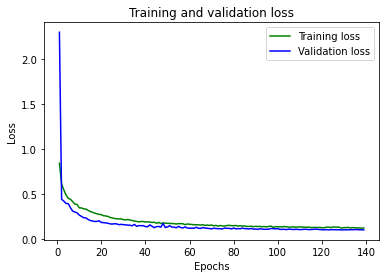

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# bo is for blue dot.
plt.plot(epochs, loss, 'g', label='Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

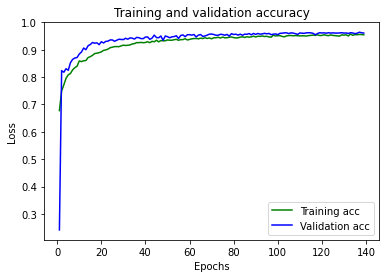

In [12]:
plt.clf()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()